# Direct sampling with Gaussian process regression

#### Import general modules

mpi4py is always required when using these tools. Numpy is always good to have if any manipulation is to be done.

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

#### Import modules from pynektools

In this case we will import all the data types that we currently support, as well as io functions that are required to populate them.

In [2]:
# Data types
from pynektools.datatypes.msh import Mesh
from pynektools.datatypes.coef import Coef
from pynektools.datatypes.field import Field, FieldRegistry

# Readers
from pynektools.io.ppymech.neksuite import preadnek, pynekread

# Writers
from pynektools.io.ppymech.neksuite import pwritenek, pynekwrite

fname = '/home/adperez/cpc_gaussian_process_compression/data/mixlay/mixlay0.f00001'
#fname = '/home/adperez/Documents/gaussian_process/Gaussian Process_0823/data/turbPipe/turbPipe0.f00001'


## Read the data

In [3]:
msh = Mesh(comm, create_connectivity=False)
fld = FieldRegistry(comm)

pynekread(fname, comm, data_dtype=np.double, msh = msh, fld = fld)


for e in range(msh.nelv):
    if (np.min(msh.x[e]), np.max(msh.x[e])) == (0, 0.25):
        if (np.min(msh.y[e]), np.max(msh.y[e])) == (0, 1.1399999856948853):
            print(e)
    
coef = Coef(msh=msh, comm=comm)

2025-02-20 15:54:12,640 - Mesh - INFO - Initializing empty Mesh object.
2025-02-20 15:54:12,641 - Field - INFO - Initializing empty Field object
2025-02-20 15:54:12,642 - pynekread - INFO - Reading file: /home/adperez/cpc_gaussian_process_compression/data/mixlay/mixlay0.f00001
2025-02-20 15:54:12,649 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-02-20 15:54:12,650 - Mesh - INFO - Initializing common attributes.
2025-02-20 15:54:12,650 - Mesh - INFO - Getting vertices
2025-02-20 15:54:12,652 - Mesh - INFO - Getting edge centers
2025-02-20 15:54:12,658 - Mesh - INFO - Facet centers not available for 2D
2025-02-20 15:54:12,659 - Mesh - INFO - Mesh object initialized.
2025-02-20 15:54:12,660 - Mesh - INFO - Mesh data is of type: float64
2025-02-20 15:54:12,660 - Mesh - INFO - Elapsed time: 0.011673687000000002s
2025-02-20 15:54:12,661 - pynekread - INFO - Reading field data
2025-02-20 15:54:12,666 - pynekread - INFO - File read
2025-02-20 15:54:12,667 - pynekread - INF

## Initialize the Direct sampler

In [4]:
from pynektools.compression.gpc_direct_sampling import DirectSampler

ds = DirectSampler(comm=comm, msh=msh, coef=coef)

In [ ]:
#ds.estimate_covariance("average", elements_to_average=100)
#ds.sample(method="fixed_bitrate", n_samples=63)

ds.log.tic()
n_samples = 32
bitrate = n_samples/(msh.lx*msh.ly*msh.lz)
ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="svd", compression_method="fixed_bitrate", bitrate = bitrate, covariance_keep_modes=5)
#ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="average", covariance_elements_to_average=int(msh.nelv/16), compression_method="fixed_bitrate", bitrate = bitrate)
#ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="average", covariance_elements_to_average=msh.nelv, compression_method="fixed_bitrate", bitrate = bitrate)
ds.log.toc()

2025-02-20 15:54:12,754 - DirectSampler - INFO - Sampling the field with options: covariance_method: {covariance_method}, compression_method: {compression_method}
2025-02-20 15:54:12,755 - DirectSampler - INFO - Estimating the covariance matrix
2025-02-20 15:54:12,756 - DirectSampler - INFO - Transforming the field into to legendre space
2025-02-20 15:54:12,761 - DirectSampler - INFO - Estimating the covariance matrix using the averaging method method. Averaging over 1600 elements at a time
2025-02-20 15:54:12,763 - DirectSampler - INFO - Covariance saved in field data_to_compress["u"]["kw"]
2025-02-20 15:54:12,764 - DirectSampler - INFO - Sampling the field using the fixed bitrate method. using settings: {'method': 'fixed_bitrate', 'bitrate': np.float64(0.5), 'n_samples': 32}
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  

In [6]:
# Hack it a bit to make the rest work

ds.field = fld.registry["u"]
ds.field_sampled = ds.data_to_compress["u"]["field"]

if ds.settings["covariance"]["method"] == "svd":
    U = ds.data_to_compress["u"]["U"]
    s = ds.data_to_compress["u"]["s"]
    vt = ds.data_to_compress["u"]["Vt"]

    if ds.kw_diag == True:
        ds.kw = U @ np.diag(s) @ vt
    else:
        ds.kw = U @ np.diag(s) @ vt
        ds.kw = ds.kw.reshape((ds.kw.shape[0], ds.kw.shape[1], 1))
else:
    ds.kw = ds.data_to_compress["u"]["kw"]
ds.elements_to_average = ds.settings["covariance"]["elements_to_average"]
ds.n_samples = ds.settings["compression"]["n_samples"]

In [7]:
ind_50 = np.where(ds.field_sampled[0] == -50)
#print(ds.field[0])
#print(ds.field_sampled[0])
a = abs(ds.field_sampled[0])-abs(ds.field[0])
a[ind_50] = -50
print(a)

[[[  0. -50.   0.   0. -50.   0. -50.   0.]
  [  0. -50.   0. -50. -50. -50. -50.   0.]
  [  0.   0. -50. -50. -50. -50.   0.   0.]
  [-50.   0.   0.   0.   0. -50.   0. -50.]
  [  0. -50. -50. -50. -50. -50. -50.   0.]
  [-50. -50.   0.   0. -50. -50.   0. -50.]
  [  0. -50. -50.   0.   0. -50. -50.   0.]
  [  0.   0.   0. -50. -50.   0.   0.   0.]]]


In [8]:

print(ds.field_hat[1466].reshape(-1,1, order='F'))

print("======")

print(ds.field_sampled[1466].reshape(-1,1, order='F'))

[[ 1.99990441e-01]
 [-5.57531503e-06]
 [-1.80462288e-08]
 [ 7.00211732e-09]
 [-9.51879178e-09]
 [ 2.13566155e-09]
 [-5.95115817e-10]
 [-5.36121616e-10]
 [-8.59488645e-06]
 [-5.00078505e-06]
 [-3.83074439e-09]
 [ 8.52690949e-09]
 [-8.40598942e-09]
 [ 2.39046847e-09]
 [-8.58811016e-10]
 [-2.42388614e-10]
 [-2.37776126e-06]
 [-1.36844321e-06]
 [ 1.57842481e-08]
 [ 5.69112633e-09]
 [-2.72724125e-09]
 [ 4.27633113e-10]
 [-4.92429909e-10]
 [ 4.96550225e-10]
 [ 1.13080070e-07]
 [ 7.57060759e-08]
 [ 1.00539981e-08]
 [ 8.09318145e-10]
 [-2.86645941e-10]
 [ 2.32829433e-10]
 [ 1.42264199e-10]
 [ 4.43830162e-10]
 [ 8.43976818e-08]
 [ 4.96585829e-08]
 [-1.09479314e-09]
 [ 8.54305353e-10]
 [ 9.55948182e-10]
 [-8.39331422e-10]
 [ 3.69644683e-10]
 [ 2.50419075e-10]
 [-1.66313403e-08]
 [-1.06633414e-08]
 [-2.55425789e-09]
 [-9.41682210e-11]
 [ 1.41116511e-09]
 [-6.89430439e-10]
 [ 6.21008604e-11]
 [ 1.17915297e-09]
 [-4.47323203e-09]
 [-2.63863014e-09]
 [-1.17943747e-09]
 [-1.12387309e-09]
 [ 1.3693124

In [9]:
recon = ds.predict(ds.field_sampled)

1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)
1: (1, 64)
2: (64,)


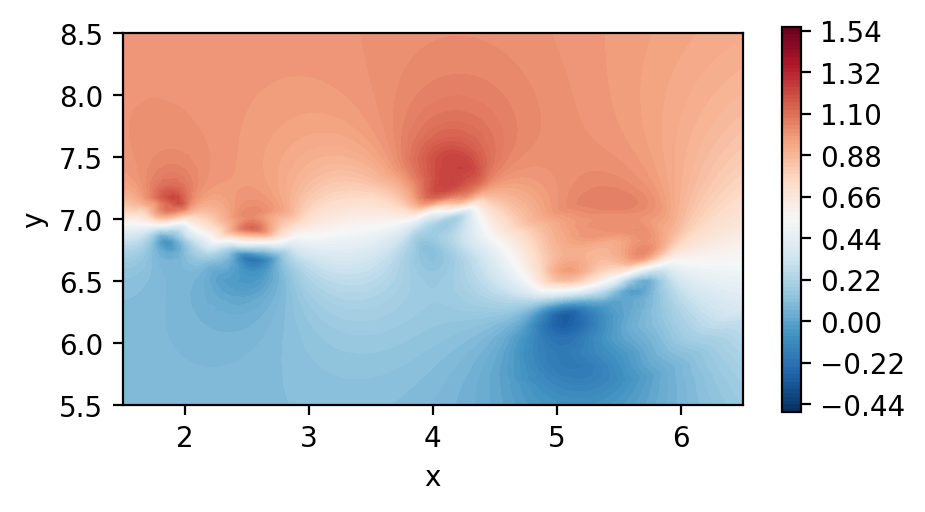

In [10]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

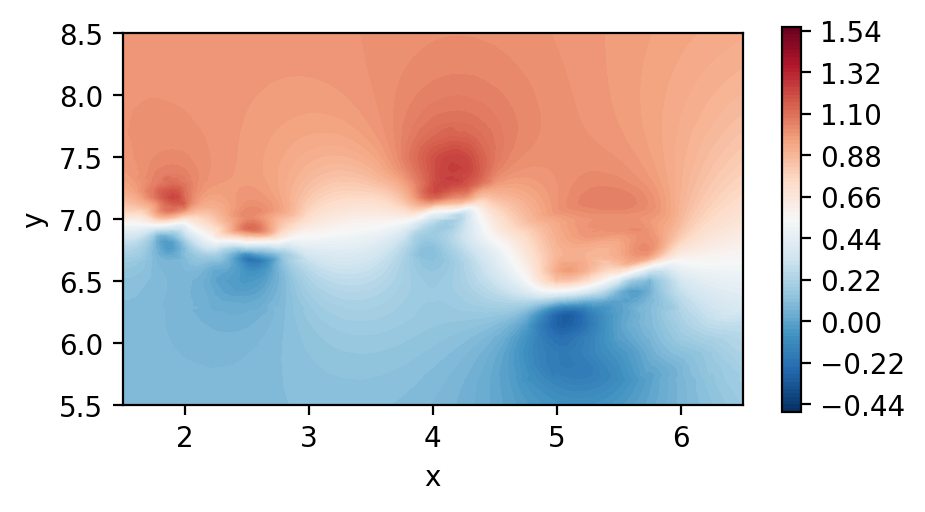

In [11]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
#c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() , fld.registry["u"].flatten() - recon.flatten(), levels=100, cmap="RdBu_r")
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,recon.flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

In [12]:
print(np.mean(fld.registry["u"] - recon))
print(np.max(abs(fld.registry["u"] - recon)))
print(np.min(abs(fld.registry["u"] - recon)))

3.304381380529114e-06
0.18754215566775845
0.0
